In [359]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams, colors, gridspec
import statistics
import scipy.stats as sts
import string
from scipy import interpolate
import random

In [360]:
def load_files(property, type):
    ensembles_full = np.loadtxt(f'data_{property}/ensemble_{property}_mean.csv',delimiter=',') # this is actually both mean and tend
    ensembles_list = ensembles_full[:,0] if (type=='mean') else ensembles_full[:,1]
    
    data   = np.loadtxt(f'data_{property}/dycoms_data_low_nd_{property}_{type}.csv', delimiter=',')
    ppe    = data[:,2]
    ppe_th = data[:,0]
    ppe_qt = data[:,1] 
    return ensembles_list, ppe, ppe_th, ppe_qt

def calculate_residuals(array1d):
    mean = np.mean(array1d)
    residuals = np.array([(val - mean) for val in array1d])
    return residuals

def sample_var(array1d):
    mean       = np.mean(array1d)
    deviations = [(element - mean)**2 for element in array1d]
    variance   = np.sum(deviations)/(len(array1d)-1)
    return variance

ensemble_ppe_nums = [3,9,11,14,15,17,18,19,20]
ensemble_indices  = np.array([num - 1 for num in ensemble_ppe_nums])

In [395]:
### Set up noise file
property  = "cloud_frac"
type      = "teme"
selection = "slice"    # "all" or "slice"

# Select which ensembles to use by the index of ensemble_indices e.g., [0,2] uses ensembles 3 and 11
# NEW TWO REGIME SLICES: for LWP: [0,2] & for CF: [2,3]
# NEW THREE REGIME SLICES: for LWP: [0,1,2] & for CF: [1,2,3]
eslice    = [3]

# Create file name
length  = 9 if selection=="all" else len(eslice)+1
nv_name = f"{selection}_{length}"

# Load ensembles and reshape
ensembles_list, ppe, ppe_th, ppe_qt = load_files(property, type)
ensembles_array = np.reshape(ensembles_list, (9,5))

In [396]:
# Calculate residuals and select which ensemble members to use
residuals = np.zeros(np.shape(ensembles_array))

for i, ensembles_row in enumerate(ensembles_array):
    residuals[i,:] = calculate_residuals(ensembles_row)

if selection == "all":
    selected_residuals = residuals
    selected_ensembles = ensembles_array
elif selection == "slice":
    selected_residuals = np.array([residuals[i] for i in eslice])
    selected_ensembles = np.array([ensembles_array[i] for i in eslice])

ensemble_variance = [sample_var(ensemble) for ensemble in selected_residuals]

In [397]:
# Apply whole variance on each ppe member based on Euclidean distance (assuming behaviour is changing smoothly)
selection_indices = ensemble_indices[eslice] if selection == "slice" else ensemble_indices
ppe_variance = np.zeros(np.shape(ppe))
colours = []
ensemble_num = 0

for i, colour in enumerate(ppe):
    if i in selection_indices:
        ppe_variance[i] = ensemble_variance[ensemble_num]
        multiply_mean   = np.mean(selected_ensembles[ensemble_num])
        colours.append(f"C{ensemble_num}")
        ensemble_num   += 1
    else:
        distances = []
        for j in selection_indices:
            x2 = (ppe_th[i] - ppe_th[j])**2
            y2 = (ppe_qt[i] - ppe_qt[j])**2
            distances.append(np.sqrt(x2 + y2))
        ppe_variance[i] = ensemble_variance[np.argmin(distances)]
        multiply_mean   = np.mean(selected_ensembles[np.argmin(distances)])
        colours.append(f"C{np.argmin(distances)}")

        # Hacky code to apply cloud_frac over different regime split
        if property == "cloud_frac":
            if i in [10,17,37]:
                ppe_variance[i] = sample_var(ensembles_array[2])  # variance of PPE 11
                multiply_mean   = np.mean(ensembles_array[2])
                colours[-1]     = f"C{len(eslice)+1}"
            # if i==17:
            #     ppe_variance[i] = sample_var(ensembles_array[6])  # variance of PPE 18
            #     multiply_mean   = np.mean(ensembles_array[6])
            #     colours[-1] = f"C{len(eslice)+2}"

In [398]:
# Print values
print(f"Selected ensembles: \n{selected_ensembles}")
print(f"Selected residual: \n{selected_residuals}")
print(f"Ensemble variance: \n{ensemble_variance}")
print(f"PPE variance: \n{ppe_variance}")

Selected ensembles: 
[[-0.01547952 -0.02413236 -0.01900606 -0.02030694 -0.02089097]]
Selected residual: 
[[ 0.00448365 -0.00416919  0.00095711 -0.00034377 -0.00092781]]
Ensemble variance: 
[9.845078196337099e-06]
PPE variance: 
[9.84507820e-06 9.84507820e-06 9.84507820e-06 9.84507820e-06
 9.84507820e-06 9.84507820e-06 9.84507820e-06 9.84507820e-06
 9.84507820e-06 9.84507820e-06 3.84071446e-06 9.84507820e-06
 9.84507820e-06 9.84507820e-06 9.84507820e-06 9.84507820e-06
 9.84507820e-06 3.84071446e-06 9.84507820e-06 9.84507820e-06
 9.84507820e-06 9.84507820e-06 9.84507820e-06 9.84507820e-06
 9.84507820e-06 9.84507820e-06 9.84507820e-06 9.84507820e-06
 9.84507820e-06 9.84507820e-06 9.84507820e-06 9.84507820e-06
 9.84507820e-06 9.84507820e-06 9.84507820e-06 9.84507820e-06
 9.84507820e-06 3.84071446e-06 9.84507820e-06]


In [399]:
# Save files
np.savetxt(f"noise_files/nv_{property}_{type}_{nv_name}.csv", ppe_variance, delimiter=',')
np.savetxt(f"noise_files/residuals/nv_{property}_{type}.csv", residuals, delimiter=',')

### =============
### Make figures 
### =============

In [93]:
# Set fonts for figures
font=22
tickfont=18
legendfont=18
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': font})

plt.rc('font', size=font)        # controls default text sizes
plt.rc('axes', labelsize=font)   # fontsize of the x and y labels
plt.rc('xtick', labelsize=tickfont)    # fontsize of the tick labels
plt.rc('ytick', labelsize=tickfont)    # fontsize of the tick labels
plt.rc('legend', fontsize=legendfont)

### Plot ensembles and residuals

mean: 0.28223253333333337, ensemble var: 0.00011007611164444408, residual var: 0.00011007611164444409
mean: 0.4836608, ensemble var: 2.8139812977777915e-05, residual var: 2.8139812977777915e-05
mean: 0.7344789333333333, ensemble var: 0.0005737157319111089, residual var: 0.0005737157319111089
mean: 0.7591605333333333, ensemble var: 0.0003841893205333325, residual var: 0.0003841893205333326
mean: 0.7658058666666666, ensemble var: 0.0008595072369777817, residual var: 0.0008595072369777818
mean: 0.8616245333333333, ensemble var: 0.0015740399018666666, residual var: 0.0015740399018666666
mean: 0.8874549333333335, ensemble var: 0.0009540584305777752, residual var: 0.0009540584305777754
mean: 0.9331541333333332, ensemble var: 0.00036693136497777926, residual var: 0.00036693136497777926
mean: 0.9380586666666666, ensemble var: 0.0006460639431111112, residual var: 0.0006460639431111111


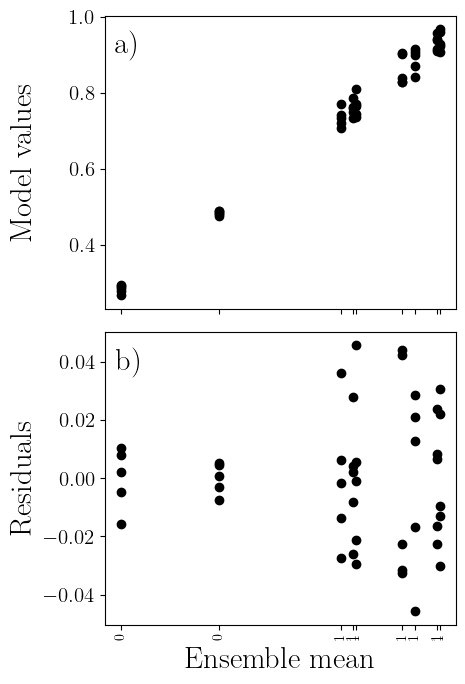

In [392]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(4.5,7), sharex=True)
plt.subplots_adjust(left=0.2,top=0.98,right=0.98,hspace=0.08)

stats     = np.zeros((len(ensemble_indices),3))
mean_list = [] 
for i, ind in enumerate(ensemble_indices):
    mean = np.mean(ensembles_array[i,:])
    ensemble_var = sample_var(ensembles_array[i])
    residual_var = sample_var(residuals[i])
    stats[i] = np.array([mean, ensemble_var, residual_var])
    mean_list.append(mean)
    
    ax[0].scatter([mean]*5, ensembles_array[i,:],c='black')
    ax[1].scatter([mean]*5, residuals[i,:],c='black')
    
stats = stats[stats[:,0].argsort()]
for row in stats:
    print(f"mean: {row[0]}, ensemble var: {row[1]}, residual var: {row[2]}")

ax[1].set_xticks(mean_list)
ax[1].set_xticklabels([f'{val:0.0f}' for val in mean_list], fontsize=10, rotation=90)
ax[1].set_xlabel("Ensemble mean")
ax[0].set_ylabel("Model values")
ax[1].set_ylabel("Residuals")
rcParams['ytick.labelsize'] = 15
fig.align_labels()
for ax, letter in zip([ax[0], ax[1]], ['a', 'b']):
    ax.text(0.03,0.87,f'{letter})',transform=ax.transAxes,fontsize=font)

In [96]:
plt.savefig(f"figures/ensemble_variances_{property}_{type}.png")
plt.savefig(f"figures/ensemble_variances_{property}_{type}.pdf")

<Figure size 640x480 with 0 Axes>

### Visualising the points sorted by Euclidean neighbour

Text(0.5, 0, '$\\Delta \\theta$ (K)')

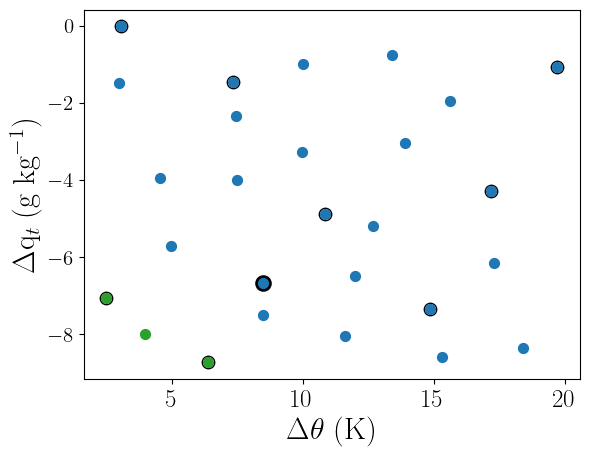

In [400]:
fig, ax = plt.subplots()

th_ensemble = np.r_[ppe_th[:20], ppe_th[32:]]
qt_ensemble = np.r_[ppe_qt[:20], ppe_qt[32:]]
colours_ensemble = colours[:]
del colours_ensemble[20:32]

for i, (th, qt) in enumerate(zip(th_ensemble, qt_ensemble)):
    if i in ensemble_indices:
        ax.scatter(th, qt, facecolor='white', edgecolor='black', s=80)
    if i in selection_indices:
        ax.scatter(th, qt, facecolor='white', edgecolor='black', s=80, linewidth=3)
    ax.scatter(th, qt, c=colours_ensemble[i], s=50)

ax.set_ylabel('$\Delta$q$_{t}$ (g kg$^{-1}$)')
ax.set_xlabel(r'$\Delta \theta$ (K)')

#ax.set_ylim(-22,0)
#ax.set_xlim(0,22)

### Making nugget comparison plot

In [264]:
def prepare_data(property, type, noise_list):
    Data = {}

    model_data = np.loadtxt(f"data_{property}/dycoms_data_low_nd_{property}_{type}.csv", delimiter=',')
    Data['train_input']  = np.concatenate((model_data[:20,:-1], model_data[32:38,:-1]))
    Data['train_output'] = np.concatenate((model_data[:20,-1], model_data[32:38,-1]))
    Data['val_input']    = model_data[24:32,:-1]
    Data['val_output']   = model_data[24:32,-1]
    
    ensemble_data     = np.loadtxt(f'ensembles_csv/ensemble_{property}_mean.csv', delimiter=',')
    property_ensemble = ensemble_data[:,0] if type == 'mean' else ensemble_data[:,1]
    Data['ensembles'] = np.reshape(property_ensemble, [9,5])

    residuals = np.loadtxt(f'noise_files/residuals/nv_{property}_{type}.csv', delimiter=',')
    Data['residuals'] = np.reshape(residuals, np.size(residuals))

    for nv_type in noise_list:
        Data[f'{nv_type}_design'] = np.loadtxt(f'predictions/{property}/pre_design_{property}_{type}_{nv_type}.csv',delimiter=',',skiprows=1)
        Data[f'{nv_type}_val']    = np.loadtxt(f'predictions/{property}/pre_val_{property}_{type}_{nv_type}.csv',delimiter=',',skiprows=1)
        Data[f'{nv_type}_pred']   = np.loadtxt(f'predictions/{property}/pre_tot_{property}_{type}_{nv_type}.csv',delimiter=',',skiprows=1)

    return Data

In [407]:
def nugget_figure(Data, Options, noise_list, titles, output_label, levels, cmap, norm, extend, hist_lim_y, bins):
    columns = len(noise_list)
    fig = plt.figure(figsize=(columns*3,9))
    gs1 = gridspec.GridSpec(2,columns,left=0.07,bottom=0.43,top=0.95,right=0.86,hspace=0.1,wspace=0.11)
    gs2 = gridspec.GridSpec(1,columns,left=0.07,bottom=0.1,top=0.34,right=0.86,hspace=0.1,wspace=0.11)
    caxspec = gridspec.GridSpec(1,1,left=0.87,bottom=0.7,top=0.95,right=0.89)

    top_row    = dict([(key, fig.add_subplot(gs1[i])) for i, key in enumerate(string.ascii_lowercase[:columns])])
    mid_row    = dict([(key, fig.add_subplot(gs1[i+columns])) for i, key in enumerate(string.ascii_lowercase[:columns])])
    bottom_row = dict([(key, fig.add_subplot(gs2[i])) for i, key in enumerate(string.ascii_lowercase[:columns])])
    cax = fig.add_subplot(caxspec[0])

    for i, (letter, nv_type, title) in enumerate(zip(string.ascii_lowercase, noise_list, titles)):
        # RMSE
        rmse = np.mean((np.subtract(Data['val_output'], Data[f'{nv_type}_val'][:,1])**2))**0.5

        if output_label == "CF tend. (hr$^{-1}$)":
            rmse_height = 0.85
        else:
            rmse_height = 0.03
        
        mid_row[letter].text(0.97,rmse_height,'RMSE = {:.3}'.format(rmse), transform=mid_row[letter].transAxes, 
                             fontsize=legendfont, horizontalalignment="right", verticalalignment="bottom")

        # Shape emulator mean function
        response = np.reshape(Data[f'{nv_type}_pred'][:,1], (Options['grid_size'], Options['grid_size']))
        
        # Response surface
        t_line = top_row[letter].plot(Options['transect'][:,0], Options['transect'][:,1], color='orangered')
        cobj   = top_row[letter].contourf(Options['meshgridX'], Options['meshgridY'], response, levels, cmap=cmap, norm=norm, extend=extend)
        cobj   = top_row[letter].contourf(Options['meshgridX'], Options['meshgridY'], response, levels, cmap=cmap, norm=norm, extend=extend)

        ppe = top_row[letter].scatter(Data['train_input'][:,0], Data['train_input'][:,1], c=Data['train_output'], cmap=cmap, norm=norm, s=Options['dsize'], marker='o', linewidth=Options['edgesize'], edgecolor='black')

        if "_9" in nv_type:
            eslice = [3,9,11,14,15,17,18,19,20]
            eslice = [num -1 for num in eslice]
        elif "_5" in nv_type:
            eslice = [3,9,11,14,15]
            eslice = [num -1 for num in eslice]
        elif "_2" in nv_type:
            if property=="cloud_frac":
                eslice = [11, 14]
                eslice = [num -1 for num in eslice]
            else:
                eslice = [3,11]
                eslice = [num -1 for num in eslice]
        else:
            eslice = []
        ensembles = top_row[letter].scatter(Data['train_input'][eslice,0], Data['train_input'][eslice,1], c=Data['train_output'][eslice], 
                                            cmap=cmap, norm=norm, s=Options['dsize'], marker='o', linewidth=2*Options['edgesize'], edgecolor="orangered") #"#2D93AD"

        top_row[letter].plot(Options['k_x'], Options['k_y'], color='black', linestyle='--')
        
        top_row[letter].set_ylim(Options['y_limits'])
        top_row[letter].set_xlim(Options['x_limits'])
        
        # Transect plot
        l95 = np.reshape(Data[f'{nv_type}_pred'][:,3], (Options['grid_size'], Options['grid_size']))
        u95 = np.reshape(Data[f'{nv_type}_pred'][:,4], (Options['grid_size'], Options['grid_size']))
        
        transect_vals = []
        upper_tvals = []
        lower_tvals = []
        theta_list50 = []
        for n,m in zip(Options['transect'][:,0],Options['transect'][:,1]):
                idn = (np.abs(np.array(Options['theta_list'])-n)).argmin()
                idm = (np.abs(np.array(Options['qt_list'])-m)).argmin()
                transect_vals.append(response[idn,idm])
                upper_tvals.append(u95[idn,idm])
                lower_tvals.append(l95[idn,idm])
                theta_list50.append(Options['theta_list'][idn])

        transect_line, = mid_row[letter].plot(theta_list50, transect_vals, color='black')
        upper_line,    = mid_row[letter].plot(theta_list50, upper_tvals, color='black', linestyle='dashed')
        lower_line,    = mid_row[letter].plot(theta_list50, lower_tvals, color='black', linestyle='dashed')

        # Histograms
        reps=50
        surface_residuals = np.empty((len(Data['train_output']), reps))
        random.seed(11)
        for rep in range(reps):
            # Randomly pick which ensemble member to use for each ensemble training point and calculate surface residuals
            # multiple times using new generations.
            for i,j in enumerate([3,9,11,14,15,17,18,19,20]):
                Data['train_output'][j-1] = Data['ensembles'][i][random.randint(0,4)]

            surface_residuals[:,rep] = np.array([(real - pred) for real, pred in zip(Data['train_output'], Data[f'{nv_type}_design'][:,1])])

        # Plot a histogram for each generated set and take the mean values for bins
        distribution_arr = np.empty((len(bins)-1,reps))
        for i, col in enumerate(surface_residuals.transpose()):
            freq, bins_array = np.histogram(col,bins=bins,density=True)
            distribution_arr[:,i] = freq
        n2 = np.mean(distribution_arr,axis=1)

        model_residuals = Data['residuals']
            
        n1, bin_array, p1 = bottom_row[letter].hist(model_residuals, alpha=0.5, color="darkorange",  bins=bins, density=True, label="Model")  # #CE8964
        bars = bottom_row[letter].bar(bin_array[:-1], n2, width=np.diff(bin_array), alpha=0.5, color="#2D93AD",align='edge', label="Emulator")
        
        #print("n1 sum: ", sum(n1))
        #print("n2 sum: ", sum(n2))
        minimums = [min(x,y) for x,y in zip(n1,n2)]
        overlap  = sum(minimums)/sum(n1) # divided to make a fraction
        # using all the randomly picked combos:
        kstat    = sts.ks_2samp(model_residuals, np.reshape(surface_residuals,np.size(surface_residuals))) 
        # averaging over the reps instead and just using the mean of the randomly picked residuals
        # (it's not just zero because the surface bending through the nugget space so there are more +ve or -ve values on each one
        # or if it's zero it's going through the middle anyway)
        #kstat    = sts.ks_2samp(model_residuals, np.mean(surface_residuals, axis=1)) 
        bottom_row[letter].text(0.03,0.95, 'KS p-val: \n{:0.2f}'.format(kstat[1]), fontsize=legendfont, transform=bottom_row[letter].transAxes, 
                                horizontalalignment="left", verticalalignment="top")
        bottom_row[letter].text(0.97,0.95, 'Overlap: \n{:0.2f}'.format(overlap), fontsize=legendfont, transform=bottom_row[letter].transAxes, 
                                horizontalalignment="right", verticalalignment="top")
        bottom_row[letter].set_ylim(hist_lim_y)
        
        # Single axis formatting
        if letter!='a':
            top_row[letter].yaxis.set_visible(False)
            mid_row[letter].yaxis.set_visible(False)
            bottom_row[letter].yaxis.set_visible(False)
        top_row[letter].xaxis.set_visible(False)

        top_row[letter].set_title(title)

    # Figure formattting
    fig.colorbar(cobj, cax=cax, norm=norm, label=output_label,aspect=20)

    fig.text(0.475,0.365, Options['xlabel'], ha='center', va='center',fontsize=font)
    fig.text(0.012,0.85, Options['ylabel'], ha='center', va='center',rotation='vertical',fontsize=font)
    fig.text(0.012,0.55, output_label, ha='center', va='center',rotation='vertical',fontsize=font)
    fig.text(0.475,0.03, 'Residual Value', ha='center', va='center',fontsize=font)
    fig.text(0.012,0.2, 'Frequency', ha='center', va='center',rotation='vertical',fontsize=font)

    mid_row[letter].legend([transect_line, upper_line], ["Mean", "95\% bounds"], loc=(1.001, 0), handlelength=0.75, frameon=False,fontsize=legendfont,handletextpad=0.13)
    bottom_row[letter].legend(loc=(1.001, 0), handlelength=0.75, frameon=False, fontsize=legendfont,handletextpad=0.13)
    
    return fig

In [305]:
# Load cmap dictionary
cmap_type = ["mean", "teme"]
cmap_list = ["nuuk", "cork"]

cmaps = {}
for type, map in zip(cmap_type, cmap_list):
    cm_data     = np.loadtxt(f"../../colour_maps/ScientificColourMaps6/{map}/{map}.txt")
    cmap        = colors.LinearSegmentedColormap.from_list(map, cm_data)
    if type=="teme":
        cmaps[type] = cmap.reversed()
    else:
        cmaps[type] = cmap

In [306]:
# Universal settings
options_dict = {
    'xlabel'    : r'$\Delta \theta$ (K)',
    'ylabel'    : r'$\Delta q_{\textrm t}$ (g kg$^{-1}$)',
    'grid_size' : 500,
    'x_limits'  : (2, 20),
    'y_limits'  : (-9, 0),
    'dsize'     : 120,
    'edgesize'  : 1,
    'transect'  : np.loadtxt('misc/transect_points.csv', delimiter=','),
    'specific'  : [[4,8.47,10.86,13.90,15.62],[-8,-6.67,-4.90,-3.05,-1.94]],
    'k_x'       : np.linspace(2, 16.363636, 10)
}

options_dict['theta_list'] = np.linspace(options_dict['x_limits'][0], options_dict['x_limits'][1], options_dict['grid_size'])
options_dict['qt_list']    = np.linspace(options_dict['y_limits'][0], options_dict['y_limits'][1], options_dict['grid_size'])

X_, Y_ = np.meshgrid(options_dict['theta_list'], options_dict['qt_list'])
options_dict['meshgridX'] = X_
options_dict['meshgridY'] = Y_

options_dict['k_y'] = [x*(1015)*1e3/(2.47e6*(0.23-1)) for x in options_dict['k_x']]

full_noise_list = ["extras", "r_nug", "all_9", "slice_2", "2mag"]

### Cloud LWP mean

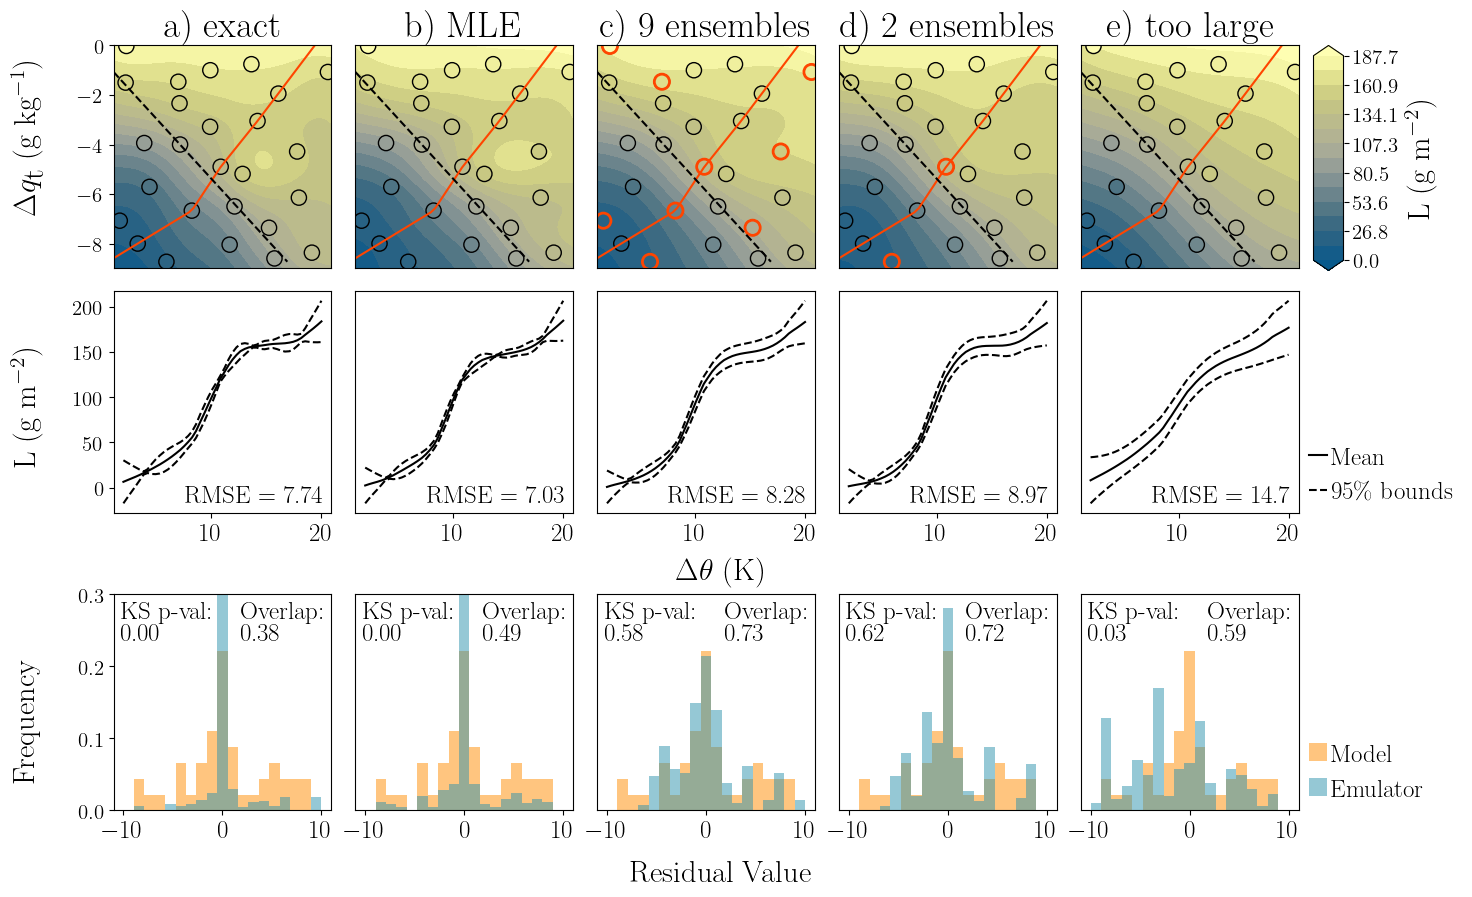

In [414]:
property = 'lwp_cloud'
type = 'mean'

lwp_Data = prepare_data(property, type, full_noise_list)

output_label = r'L (g m$^{-2}$)'
ylim = [-25, 195]

mean_min = min(lwp_Data['extras_pred'][:,1])
mean_max = max(lwp_Data['extras_pred'][:,1])
extreme  = max(abs(mean_min),abs(mean_max))

norm = colors.TwoSlopeNorm(vcenter=(mean_max/2), vmin=0, vmax=mean_max)
levels = np.linspace(0,mean_max,15)

normal = False
hist_lim_x = (-10,10)
hist_lim_y = (0,0.3)
bins = np.linspace(hist_lim_x[0],hist_lim_x[1], 20)
noise_list = ["extras", "r_nug", "all_9", "slice_2", "2mag"]
titles = ["a) exact", "b) MLE", "c) 9 ensembles", "d) 2 ensembles", "e) too large"]
fig = nugget_figure(lwp_Data, options_dict, noise_list, titles, output_label, levels, cmaps[type], norm, "both", hist_lim_y, bins)

fig.savefig("figures/nugget_lwp_mean.png")
fig.savefig("figures/nugget_lwp_mean.pdf")

### Cloud LWP tendency

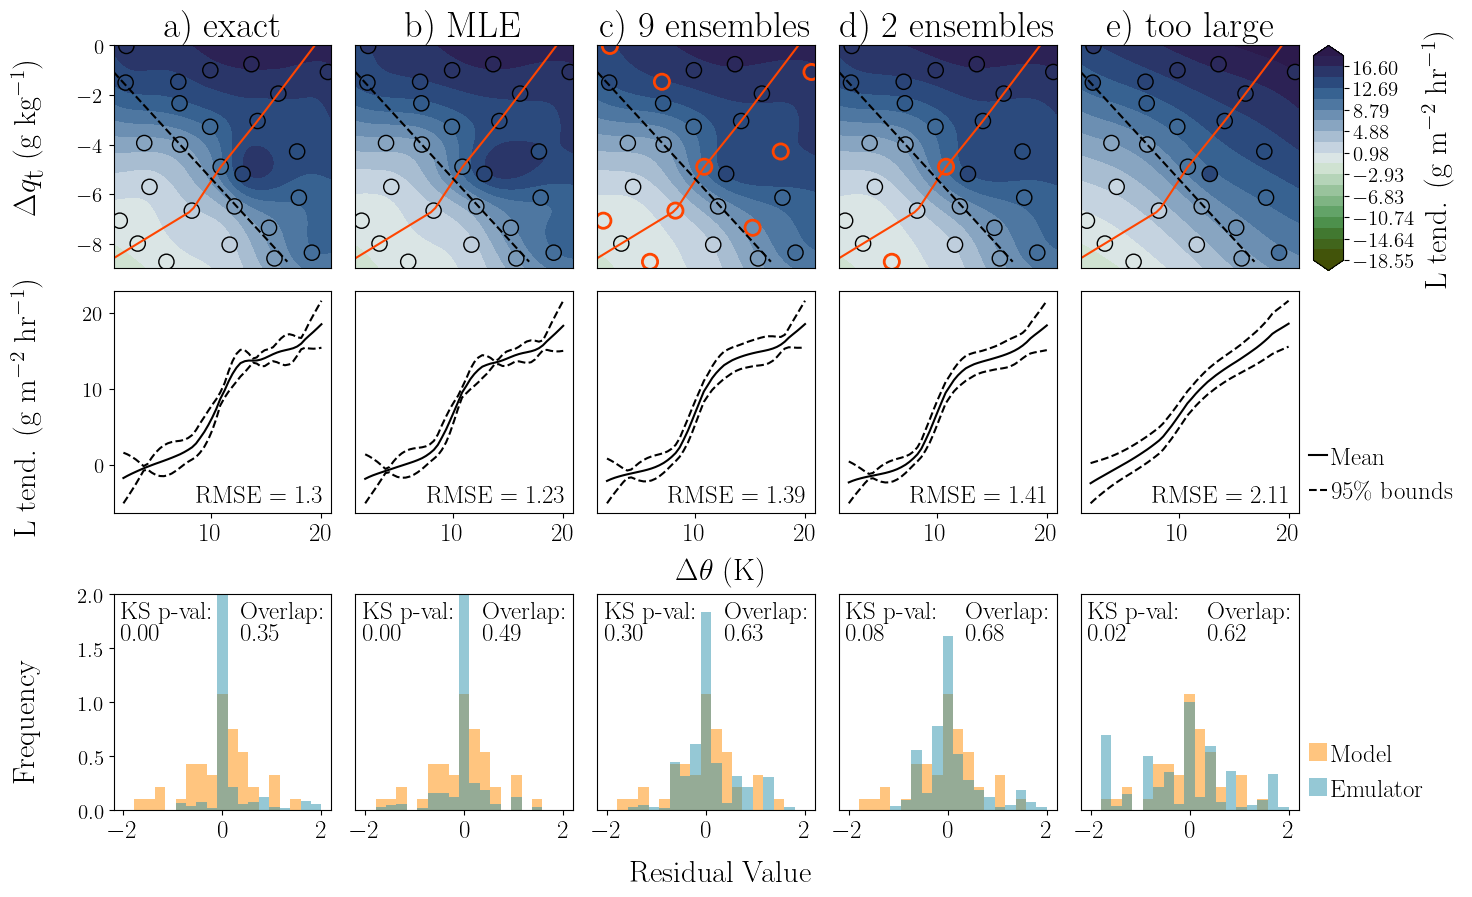

In [415]:
property = 'lwp_cloud'
type = 'teme'

lwp_teme_Data = prepare_data(property, type, full_noise_list)

output_label = "L tend. (g m$^{-2}$ hr$^{-1}$)"
ylim = [-7,24]

mean_min = min(lwp_teme_Data['extras_pred'][:,1])
mean_max = max(lwp_teme_Data['extras_pred'][:,1])
extreme  = max(abs(mean_min),abs(mean_max))

norm = colors.TwoSlopeNorm(vcenter=0, vmin=(-1)*extreme, vmax=extreme)
levels = np.linspace((-1)*extreme,extreme,20)

hist_lim_x = (-2, 2)
hist_lim_y = (0,2)
bins = np.linspace(hist_lim_x[0],hist_lim_x[1], 20)
noise_list = ["extras", "r_nug", "all_9", "slice_2", "2mag"]
titles = ["a) exact", "b) MLE", "c) 9 ensembles", "d) 2 ensembles", "e) too large"]
fig = nugget_figure(lwp_teme_Data, options_dict, noise_list, titles, output_label, levels, cmaps[type], norm, "both", hist_lim_y, bins)

fig.savefig("figures/nugget_lwp_teme.png")
fig.savefig("figures/nugget_lwp_teme.pdf")

### Cloud fraction mean

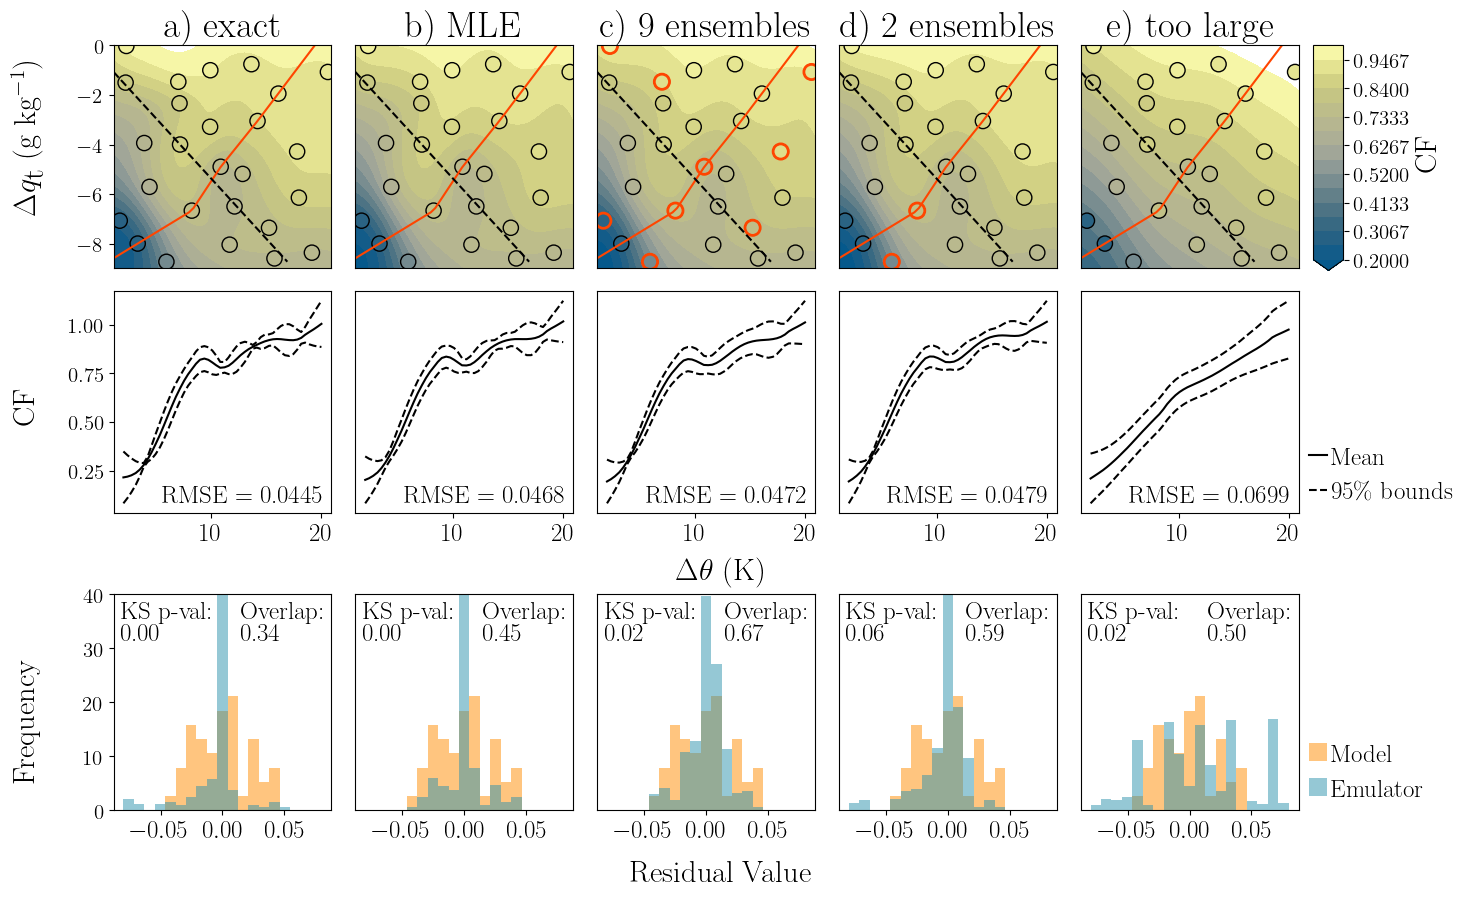

In [416]:
property = 'cloud_frac'
type = 'mean'

cf_Data = prepare_data(property, type, full_noise_list+["slice_8"])

output_label = r'CF'
ylim = [0,1.15]

mean_min = min(cf_Data['extras_pred'][:,1])
mean_max = max(cf_Data['extras_pred'][:,1])
extreme  = max(abs(mean_min),abs(mean_max))

norm = colors.TwoSlopeNorm(vcenter=0.6, vmin=0.2, vmax=1)
levels = np.linspace(0.2, 1, 16)

hist_lim_x = (-0.08, 0.08)
hist_lim_y = (0,40)
bins = np.linspace(hist_lim_x[0],hist_lim_x[1], 20)
noise_list = ["extras", "r_nug", "all_9", "slice_2", "2mag"]
titles = ["a) exact", "b) MLE", "c) 9 ensembles", "d) 2 ensembles", "e) too large"]
fig = nugget_figure(cf_Data, options_dict, noise_list, titles, output_label, levels, cmaps[type], norm, "min", hist_lim_y, bins)

fig.savefig("figures/nugget_cf_mean.png")
fig.savefig("figures/nugget_cf_mean.pdf")

### Cloud fraction tendency

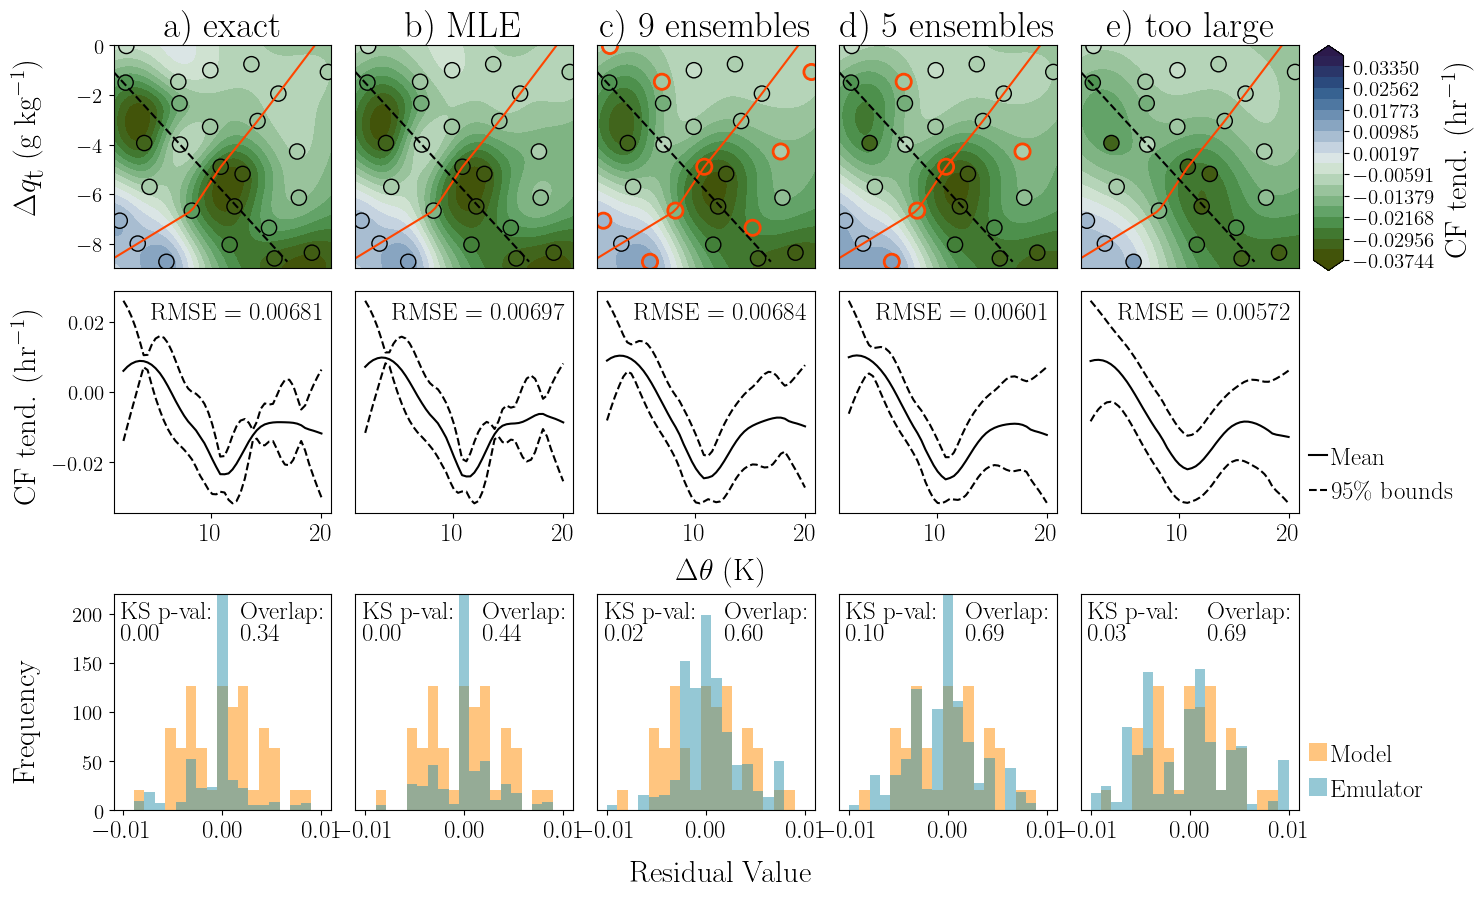

In [417]:
property = 'cloud_frac'
type = 'teme'

cf_tend_Data = prepare_data(property, type, full_noise_list+["slice_5"])

output_label = r'CF tend. (hr$^{-1}$)'
ylim = [-0.055,0.03]

mean_min = min(cf_tend_Data['extras_pred'][:,1])
mean_max = max(cf_tend_Data['extras_pred'][:,1])
extreme  = max(abs(mean_min),abs(mean_max))

norm = colors.TwoSlopeNorm(vcenter=0, vmin=(-1)*extreme, vmax=extreme)
levels = np.linspace((-1)*extreme, extreme, 20)

normal = False
hist_lim_x = (-0.01, 0.01)
hist_lim_y = (0,220)
bins = np.linspace(hist_lim_x[0],hist_lim_x[1], 20)
noise_list = ["extras", "r_nug", "all_9", "slice_5", "2mag"]
titles = ["a) exact", "b) MLE", "c) 9 ensembles", "d) 5 ensembles", "e) too large"]
fig = nugget_figure(cf_tend_Data, options_dict, noise_list, titles, output_label, levels, cmaps[type], norm, "both", hist_lim_y, bins)

fig.savefig("figures/nugget_cf_teme.png")
fig.savefig("figures/nugget_cf_teme.pdf")

### Other nuggets

In [411]:
def other_nugget_figure(top_row, mid_row, bottom_row, property, type, Data, Options, noise_list, titles, output_label, levels, cmap, norm, extend, hist_lim_y, bins):
    for i, (letter, nv_type, title) in enumerate(zip(string.ascii_lowercase, noise_list, titles)):
        # RMSE
        rmse = np.mean((np.subtract(Data['val_output'], Data[f'{nv_type}_val'][:,1])**2))**0.5

        if output_label == "CF tend. (hr$^{-1}$)":
            rmse_height = 0.85
        else:
            rmse_height = 0.03
        
        mid_row[letter].text(0.97,rmse_height,'RMSE = {:.3}'.format(rmse), transform=mid_row[letter].transAxes, 
                             fontsize=legendfont, horizontalalignment="right", verticalalignment="bottom")

        # Shape emulator mean function
        response = np.reshape(Data[f'{nv_type}_pred'][:,1], (Options['grid_size'], Options['grid_size']))
        
        # Response surface
        t_line = top_row[letter].plot(Options['transect'][:,0], Options['transect'][:,1], color='orangered')
        cobj   = top_row[letter].contourf(Options['meshgridX'], Options['meshgridY'], response, levels, cmap=cmap, norm=norm, extend=extend)
        cobj   = top_row[letter].contourf(Options['meshgridX'], Options['meshgridY'], response, levels, cmap=cmap, norm=norm, extend=extend)

        ppe = top_row[letter].scatter(Data['train_input'][:,0], Data['train_input'][:,1], c=Data['train_output'], cmap=cmap, norm=norm, s=Options['dsize'], marker='o', linewidth=Options['edgesize'], edgecolor='black')

        if "_9" in nv_type:
            eslice = [3,9,11,14,15,17,18,19,20]
            eslice = [num -1 for num in eslice]
        elif "_5" in nv_type:
            eslice = [3,9,11,14,15]
            eslice = [num -1 for num in eslice]
        elif "_2" in nv_type:
            if property=="cloud_frac":
                eslice = [11, 14]
                eslice = [num -1 for num in eslice]
            else:
                eslice = [3,11]
                eslice = [num -1 for num in eslice]
        else:
            eslice = []
        ensembles = top_row[letter].scatter(Data['train_input'][eslice,0], Data['train_input'][eslice,1], c=Data['train_output'][eslice], 
                                            cmap=cmap, norm=norm, s=Options['dsize'], marker='o', linewidth=2*Options['edgesize'], edgecolor="orangered") #"#2D93AD"

        top_row[letter].plot(Options['k_x'], Options['k_y'], color='black', linestyle='--')
        
        top_row[letter].set_ylim(Options['y_limits'])
        top_row[letter].set_xlim(Options['x_limits'])
        
        # Transect plot
        l95 = np.reshape(Data[f'{nv_type}_pred'][:,3], (Options['grid_size'], Options['grid_size']))
        u95 = np.reshape(Data[f'{nv_type}_pred'][:,4], (Options['grid_size'], Options['grid_size']))
        
        transect_vals = []
        upper_tvals = []
        lower_tvals = []
        theta_list50 = []
        for n,m in zip(Options['transect'][:,0],Options['transect'][:,1]):
                idn = (np.abs(np.array(Options['theta_list'])-n)).argmin()
                idm = (np.abs(np.array(Options['qt_list'])-m)).argmin()
                transect_vals.append(response[idn,idm])
                upper_tvals.append(u95[idn,idm])
                lower_tvals.append(l95[idn,idm])
                theta_list50.append(Options['theta_list'][idn])

        transect_line, = mid_row[letter].plot(theta_list50, transect_vals, color='black')
        upper_line,    = mid_row[letter].plot(theta_list50, upper_tvals, color='black', linestyle='dashed')
        lower_line,    = mid_row[letter].plot(theta_list50, lower_tvals, color='black', linestyle='dashed')

        # Histograms
        reps=50
        surface_residuals = np.empty((len(Data['train_output']), reps))
        random.seed(11)
        for rep in range(reps):
            # Randomly pick which ensemble member to use for each ensemble training point and calculate surface residuals
            # multiple times using new generations.
            for i,j in enumerate([3,9,11,14,15,17,18,19,20]):
                Data['train_output'][j-1] = Data['ensembles'][i][random.randint(0,4)]
            surface_residuals[:,rep] = np.array([(real - pred) for real, pred in zip(Data['train_output'], Data[f'{nv_type}_design'][:,1])])

        # Plot a histogram for each generated set and take the mean values for bins
        distribution_arr = np.empty((len(bins)-1,reps))
        for i, col in enumerate(surface_residuals.transpose()):
            freq, bins_array = np.histogram(col,bins=bins,density=True)
            distribution_arr[:,i] = freq
        n2 = np.mean(distribution_arr,axis=1)

        model_residuals = Data['residuals']
            
        n1, bin_array, p1 = bottom_row[letter].hist(model_residuals, alpha=0.5, color="darkorange",  bins=bins, density=True, label="Model")  # #CE8964
        bars = bottom_row[letter].bar(bin_array[:-1], n2, width=np.diff(bin_array), alpha=0.5, color="#2D93AD",align='edge', label="Emulator")
        
        #print("n1 sum: ", sum(n1))
        #print("n2 sum: ", sum(n2))
        minimums = [min(x,y) for x,y in zip(n1,n2)]
        overlap  = sum(minimums)/sum(n1) # divided to make a fraction
        # using all the randomly picked combos:
        kstat    = sts.ks_2samp(model_residuals, np.reshape(surface_residuals,np.size(surface_residuals))) 
        # averaging over the reps instead and just using the mean of the randomly picked residuals
        # (it's not just zero because the surface bending through the nugget space so there are more +ve or -ve values on each one
        # or if it's zero it's going through the middle anyway)
        #kstat    = sts.ks_2samp(model_residuals, np.mean(surface_residuals, axis=1)) 
        bottom_row[letter].text(0.03,0.95, 'KS p-val: \n{:0.2f}'.format(kstat[1]), fontsize=legendfont, transform=bottom_row[letter].transAxes, 
                                horizontalalignment="left", verticalalignment="top")
        bottom_row[letter].text(0.97,0.95, 'Overlap: \n{:0.2f}'.format(overlap), fontsize=legendfont, transform=bottom_row[letter].transAxes, 
                                horizontalalignment="right", verticalalignment="top")
        bottom_row[letter].set_ylim(hist_lim_y)
        
        # Single axis formatting
        if letter!='a':
            top_row[letter].yaxis.set_visible(False)
            mid_row[letter].yaxis.set_visible(False)
            bottom_row[letter].yaxis.set_visible(False)
        top_row[letter].xaxis.set_visible(False)

        
        top_row[letter].set_title(title)

    if title=="5 ensembles":
        cf_t_mid_row[letter].legend([transect_line, upper_line], ["Mean", "95\% bounds"], loc=(1.001, 0), handlelength=0.75, frameon=False,fontsize=legendfont,handletextpad=0.13)
        cf_t_bottom_row[letter].legend(loc=(1.001, 0), handlelength=0.75, frameon=False, fontsize=legendfont,handletextpad=0.13)

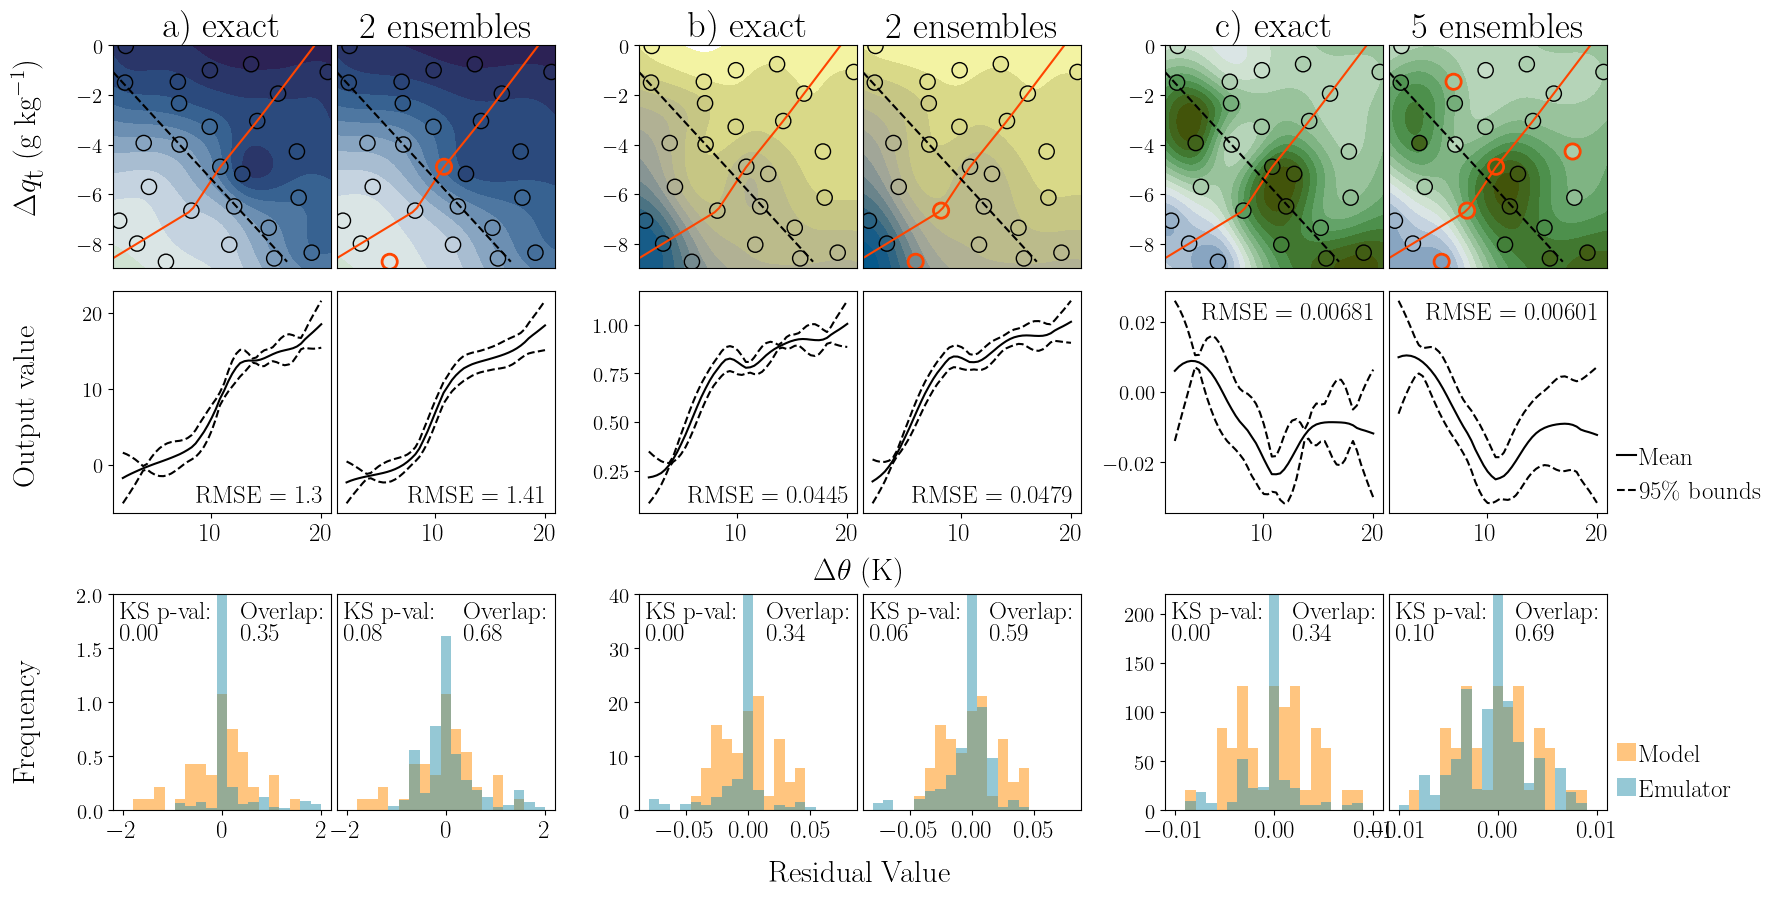

In [413]:
lwp_t_top_row={}
lwp_t_mid_row={}
lwp_t_bottom_row={}

cf_top_row={}
cf_mid_row={}
cf_bottom_row={}

cf_t_top_row={}
cf_t_mid_row={}
cf_t_bottom_row={}

fig = plt.figure(figsize=(18,9))
gs1 = gridspec.GridSpec(1,3,left=0.06,bottom=0.43,top=0.95,right=0.89,hspace=0.1,wspace=0.19)
gs1_1 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs1[0], hspace=0.1,wspace=0.025)
lwp_t_top_row['a'] = fig.add_subplot(gs1_1[0])
lwp_t_top_row['b'] = fig.add_subplot(gs1_1[1])

gs1_2 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs1[1], hspace=0.1,wspace=0.025)
cf_top_row['a'] = fig.add_subplot(gs1_2[0])
cf_top_row['b'] = fig.add_subplot(gs1_2[1])

gs1_3= gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs1[2], hspace=0.1,wspace=0.025)
cf_t_top_row['a'] = fig.add_subplot(gs1_3[0])
cf_t_top_row['b'] = fig.add_subplot(gs1_3[1])

lwp_t_mid_row['a'] = fig.add_subplot(gs1_1[2])
lwp_t_mid_row['b'] = fig.add_subplot(gs1_1[3])
cf_mid_row['a'] = fig.add_subplot(gs1_2[2])
cf_mid_row['b'] = fig.add_subplot(gs1_2[3])
cf_t_mid_row['a'] = fig.add_subplot(gs1_3[2])
cf_t_mid_row['b'] = fig.add_subplot(gs1_3[3])

gs2 = gridspec.GridSpec(1,3,left=0.06,bottom=0.1,top=0.34,right=0.89,hspace=0.1,wspace=0.19)
gs2_1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs2[0],wspace=0.025)
lwp_t_bottom_row['a'] = fig.add_subplot(gs2_1[0])
lwp_t_bottom_row['b'] = fig.add_subplot(gs2_1[1])
gs2_2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs2[1],wspace=0.025)
cf_bottom_row['a'] = fig.add_subplot(gs2_2[0])
cf_bottom_row['b'] = fig.add_subplot(gs2_2[1])
gs2_3 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs2[2],wspace=0.025)
cf_t_bottom_row['a'] = fig.add_subplot(gs2_3[0])
cf_t_bottom_row['b'] = fig.add_subplot(gs2_3[1])

normal_bool=False

property = 'lwp_cloud'
type = 'teme'

lwp_teme_Data = prepare_data(property, type, full_noise_list)

output_label = "L tend. (g m$^{-2}$ hr$^{-1}$)"
ylim = [-7,24]

mean_min = min(lwp_teme_Data['extras_pred'][:,1])
mean_max = max(lwp_teme_Data['extras_pred'][:,1])
extreme  = max(abs(mean_min),abs(mean_max))

norm = colors.TwoSlopeNorm(vcenter=0, vmin=(-1)*extreme, vmax=extreme)
levels = np.linspace((-1)*extreme,extreme,20)

normal = False
hist_lim_x = (-2, 2)
hist_lim_y = (0,2)
bins = np.linspace(hist_lim_x[0],hist_lim_x[1], 20)
other_nugget_figure(lwp_t_top_row, lwp_t_mid_row, lwp_t_bottom_row,  property, type, lwp_teme_Data, options_dict, 
                    ["extras", "slice_2"], ["a) exact", "2 ensembles"], output_label, levels, cmaps[type], norm, "both", hist_lim_y, bins)

property = 'cloud_frac'
type = 'mean'

cf_Data = prepare_data(property, type, full_noise_list)

output_label = r'CF'
ylim = [0,1.15]

mean_min = min(cf_Data['extras_pred'][:,1])
mean_max = max(cf_Data['extras_pred'][:,1])
extreme  = max(abs(mean_min),abs(mean_max))

norm = colors.TwoSlopeNorm(vcenter=0.6, vmin=0.2, vmax=1)
levels = np.linspace(0.2, 1, 12)

normal = False
hist_lim_x = (-0.08, 0.08)
hist_lim_y = (0,40)
bins = np.linspace(hist_lim_x[0],hist_lim_x[1], 20)
other_nugget_figure(cf_top_row, cf_mid_row, cf_bottom_row, property, type, cf_Data, options_dict, 
                    ["extras", "slice_2"], ["b) exact", "2 ensembles"], output_label, levels, cmaps[type], norm, "min", hist_lim_y, bins)


property = 'cloud_frac'
type = 'teme'

cf_tend_Data = prepare_data(property, type, full_noise_list+["slice_5"])

output_label = r'CF tend. (hr$^{-1}$)'
ylim = [-0.055,0.03]

mean_min = min(cf_tend_Data['extras_pred'][:,1])
mean_max = max(cf_tend_Data['extras_pred'][:,1])
extreme  = max(abs(mean_min),abs(mean_max))

norm = colors.TwoSlopeNorm(vcenter=0, vmin=(-1)*extreme, vmax=extreme)
levels = np.linspace((-1)*extreme, extreme, 20)

normal = False
hist_lim_x = (-0.01, 0.01)
hist_lim_y = (0,220)
bins = np.linspace(hist_lim_x[0],hist_lim_x[1], 20)
other_nugget_figure(cf_t_top_row, cf_t_mid_row, cf_t_bottom_row,  property, type, cf_tend_Data, options_dict, 
                    ["extras", "slice_5"], ["c) exact", "5 ensembles"], output_label, levels, cmaps[type], norm, "both", hist_lim_y, bins)

# Figure formattting
fig.text(0.475,0.365, options_dict['xlabel'], ha='center', va='center',fontsize=font)
fig.text(0.012,0.85, options_dict['ylabel'], ha='center', va='center',rotation='vertical',fontsize=font)
fig.text(0.012,0.55, "Output value", ha='center', va='center',rotation='vertical',fontsize=font)
fig.text(0.475,0.03, 'Residual Value', ha='center', va='center',fontsize=font)
fig.text(0.012,0.2, 'Frequency', ha='center', va='center',rotation='vertical',fontsize=font)

fig.savefig("figures/nugget_other_emulators.png")
fig.savefig("figures/nugget_other_emulators.pdf")